In [1]:
!pip install yfinance

In [2]:
# read files shared via google-drive-link
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# added comment: Gdown downloads a public file/folder from Google Drive.
# added comment: pip uninstall option -y : -y, --yes
#                                          Don’t ask for confirmation of uninstall deletions.

!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.2.0
Uninstalling gdown-5.2.0:
  Successfully uninstalled gdown-5.2.0
  Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
gdown 5.2.0 at /usr/local/lib/python3.10/dist-packages


In [3]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
# import plotly.graph_objs as go
# import plotly.graph_objects as go
# import plotly.express as px

import time
from datetime import date

# for graphs
# import matplotlib.pyplot as plt

# 0) Dataset for Modeling: Final Preparations

## 0.1) Importing data from Drive & defining variable sets
* automated version need to have a daily updated file/database entries

In [4]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing
!gdown https://drive.google.com/file/d/1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP/view?usp=sharing --fuzzy -O /content/


Downloading...
From (original): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP
From (redirected): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP&confirm=t&uuid=3c953657-039c-431a-90e0-e74f68040055
To: /content/stocks_df_combined_2024_05_07.parquet.brotli
100% 119M/119M [00:00<00:00, 166MB/s]


In [5]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("/content/stocks_df_combined_2024_05_07.parquet.brotli", )


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221142 entries, 0 to 5426
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.5+ MB


In [7]:
df_full.keys()

Index(['Open', 'High', 'Low', 'Close', 'Adj Close_x', 'Volume', 'Ticker',
       'Year', 'Month', 'Weekday',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=202)

In [8]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [9]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

In [10]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [11]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_5d', 'is_positive_growth_5d_future']

In [12]:
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Adj Close_y',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close_x',
 'Volume']

In [13]:
# let's define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))

In [14]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

In [15]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [16]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')


Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [17]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [18]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [19]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]
OTHER

['growth_future_5d', 'is_positive_growth_5d_future']

In [20]:
df_full.Ticker.nunique()

33

In [21]:
# tickers, min-max date, count of daily observations
df_full.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,1980-12-12,2024-05-07,10941
ACN,2001-07-19,2024-05-07,5736
AMZN,1997-05-15,2024-05-07,6789
ASML,1995-03-15,2024-05-07,7338
AVGO,2009-08-06,2024-05-07,3713
BHARTIARTL.NS,2002-07-01,2024-05-07,5424
BRK-B,1996-05-09,2024-05-07,7046
CDI.PA,1992-01-27,2024-05-07,8328
GOOG,2004-08-19,2024-05-07,4963


In [22]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 203 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 239.7+ MB


In [23]:
# let look at the features count and size:
df[NUMERICAL].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 184 entries, growth_1d to DGS10
dtypes: float64(121), int32(62), int64(1)
memory usage: 214.6 MB


## 0.2) [Code snippet 1] Generating dummies

### Question 1 (1 point): Dummies on Month and Week-of-Month

Find the ABSOLUTE CORRELATION VALUE of the most correlated dummy \<month-week_of_month\> with the binary outcome variable is_positive_growth_5d_future?

You saw in the correlation analysis and modeling that September and October may be important seasonal months. In this task, we'll go futher and try to generate dummies for Month and Week-of-month (starting from 1). For example, the first week of October should be coded similar to this: 'October_w1'. Once you've generated the new set of variables, find the most correlated (in absolute value) one with is_positive_growth_5d_future and round it to 3 digits after the comma.

Suggested path to a solution:

- [[Source](https://stackoverflow.com/questions/25249033/week-of-a-month-pandas)] Use this formula to get the week of month for the datetime variable d: `(d.day-1)//7+1`
- Define a new string variable for all month-week_of_month combinations. Append it to the CATEGORICAL features set. You should have 5 variables treated as CATEGORICAL now: 'Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom'. In the end, you should get 115 dummy features, including 60 (=12*5) week_month_of_week dummies.
- Use [pandas.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to generate dummies.
- Use [pandas.DataFrame.corr()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) function (also used in \[Code Snippet 1\]) to get correlations with is_positive_growth_5d_future, filter out only variables representing the new dummy set, and sort it by absolute values (you can define a new column "abs_corr" in the dataframe with correlations), and find the highest value (among the new dummies features set).

**NOTE:** new dummies will be used as features in the next tasks, please leave them in the dataset.


In [24]:
# what are the categorical features?
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type']

In [25]:
# dummy variables are not generated from Date and numeric variables
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

In [26]:
df['Month']

3490    January
3491    January
3492    January
3493    January
3494    January
         ...   
5422      April
5423        May
5424        May
5425        May
5426        May
Name: Month, Length: 182675, dtype: object

In [27]:
df['Weekday'].value_counts().index

Index(['2', '1', '3', '4', '0', '6', '5'], dtype='object', name='Weekday')

In [28]:
# Create a variable WoM which stands for week of the month - i.e. values of 1 to 5
df['WoM'] = df['Date'].apply(lambda d: (d.day-1) // 7 + 1)
# Check the results
df[['Date', 'WoM']]

<ipython-input-28-5027b1611b57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WoM'] = df['Date'].apply(lambda d: (d.day-1) // 7 + 1)


,Date,WoM
3490,2000-01-03,1
3491,2000-01-04,1
3492,2000-01-05,1
3493,2000-01-06,1
3494,2000-01-07,1
...,...,...
5422,2024-04-30,5
5423,2024-05-02,1
5424,2024-05-03,1
5425,2024-05-06,1


In [29]:
# Function to concatenate the month value with the week-of-the-month
def concat_month_weekofmonth( month, week_of_month):
  return month+"_w"+str(week_of_month)

In [30]:
df['Month_WoM'] = df.apply(lambda x: concat_month_weekofmonth(x["Month"], x["WoM"]), axis=1)
df[['Month', 'WoM', 'Month_WoM']]

<ipython-input-30-c12c48a4af04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month_WoM'] = df.apply(lambda x: concat_month_weekofmonth(x["Month"], x["WoM"]), axis=1)


,Month,WoM,Month_WoM
3490,January,1,January_w1
3491,January,1,January_w1
3492,January,1,January_w1
3493,January,1,January_w1
3494,January,1,January_w1
...,...,...,...
5422,April,5,April_w5
5423,May,1,May_w1
5424,May,1,May_w1
5425,May,1,May_w1


In [31]:
# Add the new categorical variable Month_WoM to CATEGORICAL
CATEGORICAL.append("Month_WoM")

CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type', 'Month_WoM']

In [32]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [33]:
# TODO 1: define more categorical features, e.g. all combinations for <September+weekday>  (you'll see that September is actually an important dummy in one of the models)

In [34]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 115 entries, Month_April to Month_WoM_September_w5
dtypes: int32(115)
memory usage: 81.5 MB


In [35]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()

In [36]:
DUMMIES

['Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'Ticker_AAPL',
 'Ticker_ACN',
 'Ticker_AMZN',
 'Ticker_ASML',
 'Ticker_AVGO',
 'Ticker_BHARTIARTL.NS',
 'Ticker_BRK-B',
 'Ticker_CDI.PA',
 'Ticker_GOOG',
 'Ticker_HDB',
 'Ticker_HINDUNILVR.NS',
 'Ticker_IBN',
 'Ticker_IDEXY',
 'Ticker_INFY',
 'Ticker_ITC.NS',
 'Ticker_JPM',
 'Ticker_LICI.NS',
 'Ticker_LLY',
 'Ticker_LT.NS',
 'Ticker_MC.PA',
 'Ticker_META',
 'Ticker_MSFT',
 'Ticker_NVDA',
 'Ticker_NVO',
 'Ticker_OR.PA',
 'Ticker_RELIANCE.NS',
 'Ticker_RMS.PA',
 'Ticker_SAP',
 'Ticker_SBIN.NS',
 'Ticker_SIE.DE',
 'Ticker_TCS.NS',
 'Ticker_TTE',
 'Ticker_V',
 'ticker_type_EU',
 'ticker_type_INDIA',
 'ticker_type_US',
 'Month_WoM_April_w1',
 'Month_WoM_April_w2',
 'Month_WoM_April_w3',
 'Mo

In [37]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [38]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 299 entries, growth_1d to Month_WoM_September_w5
dtypes: float64(121), int32(177), int64(1)
memory usage: 294.8 MB


## 0.3) [Code Snippet 2] Correlation analysis
* first approximation of "important" variables correlated with all variables we want to predict (TO_PREDICT)

In [39]:
TO_PREDICT

['growth_future_5d', 'is_positive_growth_5d_future']

### Question 1 last part
Use pandas.DataFrame.corr() function (also used in [Code Snippet 1]) to get correlations with is_positive_growth_5d_future, filter out only variables representing the new dummy set, and sort it by absolute values (you can define a new column "abs_corr" in the dataframe with correlations), and find the highest value (among the new dummies features set).

In [40]:
# Get list of WoM
MTH_WOM_DUMMIES = [ g for g in df_with_dummies.keys() if (g.find('Month_WoM')>=0) ]
MTH_WOM_DUMMIES

['Month_WoM',
 'Month_WoM_April_w1',
 'Month_WoM_April_w2',
 'Month_WoM_April_w3',
 'Month_WoM_April_w4',
 'Month_WoM_April_w5',
 'Month_WoM_August_w1',
 'Month_WoM_August_w2',
 'Month_WoM_August_w3',
 'Month_WoM_August_w4',
 'Month_WoM_August_w5',
 'Month_WoM_December_w1',
 'Month_WoM_December_w2',
 'Month_WoM_December_w3',
 'Month_WoM_December_w4',
 'Month_WoM_December_w5',
 'Month_WoM_February_w1',
 'Month_WoM_February_w2',
 'Month_WoM_February_w3',
 'Month_WoM_February_w4',
 'Month_WoM_February_w5',
 'Month_WoM_January_w1',
 'Month_WoM_January_w2',
 'Month_WoM_January_w3',
 'Month_WoM_January_w4',
 'Month_WoM_January_w5',
 'Month_WoM_July_w1',
 'Month_WoM_July_w2',
 'Month_WoM_July_w3',
 'Month_WoM_July_w4',
 'Month_WoM_July_w5',
 'Month_WoM_June_w1',
 'Month_WoM_June_w2',
 'Month_WoM_June_w3',
 'Month_WoM_June_w4',
 'Month_WoM_June_w5',
 'Month_WoM_March_w1',
 'Month_WoM_March_w2',
 'Month_WoM_March_w3',
 'Month_WoM_March_w4',
 'Month_WoM_March_w5',
 'Month_WoM_May_w1',
 'Month_Wo

In [41]:
corr_is_positive_growth_5d_future = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['is_positive_growth_5d_future']

In [42]:
# create a dataframe for an easy way to sort
corr_is_positive_growth_5d_future_df = pd.DataFrame(corr_is_positive_growth_5d_future)

In [43]:
# Filter for the month_week_of_month correlations
corr_is_positive_growth_5d_future_df = corr_is_positive_growth_5d_future_df.filter(items= MTH_WOM_DUMMIES, axis=0)

In [44]:
# Compute absoluate correlations
corr_is_positive_growth_5d_future_df['is_positive_growth_5d_future'] = corr_is_positive_growth_5d_future_df['is_positive_growth_5d_future'].apply(abs)

In [45]:
corr_is_positive_growth_5d_future_df.sort_values(by='is_positive_growth_5d_future').head(5)

,is_positive_growth_5d_future
Month_WoM_November_w1,0.000033
Month_WoM_March_w2,0.000036
Month_WoM_February_w1,0.000059
Month_WoM_October_w1,0.000225
Month_WoM_April_w2,0.000227


In [46]:
# ABSOLUTE CORRELATION VALUE of the most correlated dummy <month-week_of_month> with the binary outcome variable is_positive_growth_5d_future
# is 0.035, where dummy feature is Sept_week3
corr_is_positive_growth_5d_future_df.sort_values(by='is_positive_growth_5d_future').tail(8)

,is_positive_growth_5d_future
Month_WoM_December_w4,0.019270
Month_WoM_June_w3,0.019754
Month_WoM_May_w1,0.022040
Month_WoM_May_w4,0.022264
Month_WoM_February_w3,0.024578
Month_WoM_October_w5,0.026023
Month_WoM_March_w4,0.026058
Month_WoM_September_w3,0.034537


## 0.4) [Code snippet 3] Temporal split of ~25 years of data (by date)

### Question 2 (2 points): Define new "hand" rules on macro and technical indicators variables

What is the precision score for the best of the NEW predictions (pred3 or pred4), rounded to 3 digits after the comma?

Let's utilize the knowledge from the visualised tree (clf10) (Code Snippet 5: 1.4.4 Visualisation):

You're asked to define two new 'hand' rules (leading to 'positive' subtrees):

pred3_manual_gdp_fastd: (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)

pred4_manual_gdp_wti_oil: (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)

Extend the Code Snippet 3 (Manual "hand rule" predictions): Calculate and add new rules (pred3 and pred4) to the dataframe.You should notice that one of the predictions doesn't have any positive predictions on TEST dataset (while it has many on TRAIN+VALIDATION).

Debug: check in the new_df and the original dataset/data generation process that we didn't make any mistakes during the data transformation step.

Explain why this can happen even if there are no errors in the data features.

As a result, write down the precision score for the remaining predictor (round to three decimal points). E.g. if you have 0.57897, your answer should be 0.579.



In [47]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [48]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [49]:
# my added
min_date_df, type(min_date_df)

(Timestamp('2000-01-03 00:00:00'), pandas._libs.tslibs.timestamps.Timestamp)

In [50]:
df_with_dummies['split']

3490    train
3491    train
3492    train
3493    train
3494    train
        ...  
5422     test
5423     test
5424     test
5425     test
5426     test
Name: split, Length: 182675, dtype: object

In [51]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.675834
test          0.163290
validation    0.160876
Name: count, dtype: float64

In [52]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

# 1) Modeling: "rule of thumb" or hand-predictions

In [53]:
new_df.groupby(by='split')['growth_future_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
test,29664.0,1.005015,0.040835,0.690219,0.981994,1.004731,1.027028,1.393477
train,123458.0,1.003965,0.053826,0.412383,0.978474,1.003197,1.028354,3.018887
validation,29388.0,1.004417,0.040642,0.668581,0.985343,1.005120,1.023999,1.459217


# 1) Modeling: "rule of thumb" or hand-predictions

## 1.1) Review all the inputs again

In [54]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

In [55]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 321 entries, Open to split
dtypes: datetime64[ns](2), float64(129), int32(178), int64(6), object(6)
memory usage: 324.7+ MB


In [56]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,Month_WoM_October_w2,Month_WoM_October_w3,Month_WoM_October_w4,Month_WoM_October_w5,Month_WoM_September_w1,Month_WoM_September_w2,Month_WoM_September_w3,Month_WoM_September_w4,Month_WoM_September_w5,split
3490,58.6875,59.3125,56.0,58.28125,36.065567,53228400.0,MSFT,2000,January,0,...,0,0,0,0,0,0,0,0,0,train


In [57]:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,count,max,min
split,,,
test,29829,2024-05-07,2020-09-14
train,123458,2017-01-16,2000-01-03
validation,29388,2020-09-11,2017-01-17


In [58]:
# what we try to predict
new_df[TO_PREDICT].head(1)

,growth_future_5d,is_positive_growth_5d_future
3490,0.963003,0


In [59]:
# to be used as features
new_df[NUMERICAL+DUMMIES].head(1)

,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,Month_WoM_October_w1,Month_WoM_October_w2,Month_WoM_October_w3,Month_WoM_October_w4,Month_WoM_October_w5,Month_WoM_September_w1,Month_WoM_September_w2,Month_WoM_September_w3,Month_WoM_September_w4,Month_WoM_September_w5
3490,0.998394,0.988341,0.991494,1.372333,1.222951,2.063053,0.970196,0.983855,1.051736,1.134572,...,0,0,0,0,0,0,0,0,0,0


## 1.2) [Code Snippet 3] Manual "hand rule" predictions
* CCI (binary, on technical indicator CCI)
* growth_1d>0
* growth_1d>0 & growth_snp500_1d>0

In [60]:
# why does it work?
# compare a vector (pandas.core.series.Series) with scalar 200 ==> element_wise comparison with the number
new_df.cci>200

3490    False
3491    False
3492    False
3493    False
3494    False
        ...  
5422    False
5423    False
5424    False
5425    False
5426    False
Name: cci, Length: 182675, dtype: bool

In [61]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
# We add in the 2 new rules for the hw
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_1d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_1d'] > 1) & (new_df['growth_snp500_1d'] > 1)).astype(int)

new_df['pred3_manual_gdp_fastd'] = ((new_df.gdppot_us_yoy <= 0.027) & (new_df.fastd >= 0.251)).astype(int)
new_df['pred4_manual_gdp_wti_oil'] = ((new_df.gdppot_us_yoy >= 0.027) & (new_df.growth_wti_oil_30d <= 1.005)).astype(int)

In [62]:
# TODO 2: find more "hand rules" - can get it from decision trees important factors, or randomly build on other most popular macro/tech indicators/ manual_features

In [63]:
new_df[['cci','growth_1d','growth_snp500_1d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_gdp_fastd', 'pred4_manual_gdp_wti_oil','is_positive_growth_5d_future']]

,cci,growth_1d,growth_snp500_1d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_fastd,pred4_manual_gdp_wti_oil,is_positive_growth_5d_future
3490,26.847237,0.998394,0.990451,0,0,0,0,0,0
3491,-34.319663,0.966220,0.961655,0,0,0,0,0,0
3492,-97.318008,1.010544,1.001922,0,1,1,0,0,0
3493,-169.947507,0.966502,1.000956,0,0,0,0,0,0
3494,-142.142685,1.013068,1.027090,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...
5422,-29.424989,0.988994,0.984269,0,0,0,1,0,0
5423,-26.657181,1.001447,1.009128,0,1,1,1,0,0
5424,-123.785473,0.972302,1.012557,0,0,0,1,0,0
5425,-181.986224,0.989571,1.010326,0,0,0,1,0,0


In [64]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_fastd',
 'pred4_manual_gdp_wti_oil']

In [65]:
p = PREDICTIONS[0]
part1 = p.split('_')[0] # first prefix before '_'
print(f'Full column name: {p}, only first part: {part1}')

Full column name: pred0_manual_cci, only first part: pred0


In [66]:
# One prediction: do we predict correctly?
new_df['is_correct_prediction'] = (new_df.pred0_manual_cci == new_df.is_positive_growth_5d_future)

In [67]:
new_df[['cci','pred0_manual_cci','is_positive_growth_5d_future','is_correct_prediction']]

,cci,pred0_manual_cci,is_positive_growth_5d_future,is_correct_prediction
3490,26.847237,0,0,True
3491,-34.319663,0,0,True
3492,-97.318008,0,0,True
3493,-169.947507,0,0,True
3494,-142.142685,0,1,False
...,...,...,...,...
5422,-29.424989,0,0,True
5423,-26.657181,0,0,True
5424,-123.785473,0,0,True
5425,-181.986224,0,0,True


In [68]:
# check "Precision" : the percentage of "correct" predictions , WHEN we predict "1" (POSITIVE future growth)
filter = (new_df.split=='test') & (new_df.pred0_manual_cci==1)
new_df[filter].is_correct_prediction.value_counts()


is_correct_prediction
True     455
False    344
Name: count, dtype: int64

In [69]:
# %% of correct predictions : 54%
new_df[filter].is_correct_prediction.value_counts() / len(new_df[filter])

is_correct_prediction
True     0.569462
False    0.430538
Name: count, dtype: float64

In [70]:
# delete this column
del new_df["is_correct_prediction"]

In [71]:
# generate columns is_correct_predx
for pred in PREDICTIONS:
  part1 = pred.split('_')[0] # first prefix before '_'
  new_df[f'is_correct_{part1}'] =  (new_df[pred] == new_df.is_positive_growth_5d_future).astype(int)

In [72]:
# IS_CORRECT dataset
IS_CORRECT =  [k for k in new_df.keys() if k.startswith('is_correct_')]
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4']

In [73]:
new_df[PREDICTIONS+IS_CORRECT+['is_positive_growth_5d_future']]

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_fastd,pred4_manual_gdp_wti_oil,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_5d_future
3490,0,0,0,0,0,1,1,1,1,1,0
3491,0,0,0,0,0,1,1,1,1,1,0
3492,0,1,1,0,0,1,0,0,1,1,0
3493,0,0,0,0,0,1,1,1,1,1,0
3494,0,1,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5422,0,0,0,1,0,1,1,1,0,1,0
5423,0,1,1,1,0,1,0,0,0,1,0
5424,0,0,0,1,0,1,1,1,0,1,0
5425,0,0,0,1,0,1,1,1,0,1,0


In [74]:
len(new_df[new_df.split=='test'])

29829

In [75]:
# define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
for i,column in enumerate(IS_CORRECT):
  prediction_column = PREDICTIONS[i]
  is_correct_column = column
  filter = (new_df.split=='test') & (new_df[prediction_column]==1)
  print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
  print(new_df[filter][is_correct_column].value_counts())
  print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))

  print('---------')

Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    5726
0    4729
Name: count, dtype: int64
is_correct_pred2
1    0.547681
0    0.452319
Name: count, dtype: float64
---------
Prediction column:pred3_manual_gdp_fastd , is_correct_column: is_correct_pred3
is_correct_pred3
1    16560
0    13262
Name: count, dtype: int64
is_correct_pred3
1    0.555295
0    0.444705
Name: count, dtype: float64
---------
Prediction column:pred4_manual_gdp_wti_oil , is_correct_column: is_correct_pred4
Series([], Name: coun

In [76]:
# Here, we check why pred4_manual_gdp_wti_oil does not have any positive predictions -
# reason is that gdppot_us_yoy is never >= 0.027 for the test dataset - due to pandemic
# Note: test dataset spans the period 	2020-09-14 to 2024-05-07.
check_df = new_df[ new_df['split']=='test' ][['gdppot_us_yoy', 'growth_wti_oil_30d', 'pred4_manual_gdp_wti_oil' ]]
check_df.describe()

,gdppot_us_yoy,growth_wti_oil_30d,pred4_manual_gdp_wti_oil
count,29829.000000,29498.000000,29829.0
mean,0.020459,1.028939,0.0
std,0.001048,0.115884,0.0
min,0.019245,0.775530,0.0
25%,0.019551,0.942308,0.0
50%,0.020183,1.027873,0.0
75%,0.021312,1.109100,0.0
max,0.022251,1.484816,0.0


## 1.4) [Code Snippet 5] Binary Decision Tree

### Question 3 (1 point): Unique correct predictions from a 10-levels deep Decision Tree Classifier (pred5_clf_10)

What is the total number of records in the TEST dataset when the new prediction pred5_clf_10 is better than all 'hand' rules (pred0..pred4)?

NOTE: please include random_state=42 to Decision Tree Classifier init function (line clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)) to ensure everyone gets the same results.

Suggested solution:

Step1: Rewrite the '1.4.3 Inference for a decision tree' piece for the Decision Tree Classifier with max_depth=10 (clf_10), so that you fit the model on TRAIN+VALIDATION sets (unchanged from the lecture), but predict on the whole set X_all (to be able to define a new column 'pred5_clf_10' in the dataframe new_df). Here is the link with explanation. It will solve the problem in 1.4.5 when predictions were made only for Test dataset and couldn't be easily joined with the full dataset.

Step2: Once you have it, define a new column 'only_pred5_is_correct' similar to 'hand' prediction rules with several conditions: is_positive_growth_5d_future AND is_correct_pred5 should be equal 1, while all other predictions is_correct_pred0..is_correct_pred4 should be equal to 0.

Step3: Convert 'only_pred5_is_correct' column from bool to int, and find how many times it is equal to 1 in the TEST set. Write down this as an answer.

ADVANCED: define a function that can be applied to the whole row of predictions (a few examples of pandas-apply-row-functions) and can find whether some prediction 'predX' (where X is one of the predictions) is uniquely correct. It should work even if there are 100 predictions available, so that you don't define manually the condition for 'predX'.

In [77]:
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

### 1.4.1) Define dataframes AND perform data cleaning
* define X_train (dataframe), X_test (dataframe), y_train (series), y_test (series)
* replace +-inf. with 0
* fill NaNs with 0 (you can drop it too, but will loose a lot of data in our case
* remove 1-2% outliers (in each dimension, or only in variable to_predict :: we won't use it for a Decision Tree

In [78]:
# Decision Tree doesn't like too large and inf. values
import numpy as np

def remove_infinite_values(X):
    """
    Remove infinite values from the input array.

    Parameters:
    - X: Input array (NumPy array or array-like)

    Returns:
    - Array with infinite values removed
    """
    return X[np.isfinite(X).all(axis=1)]

# Example usage:
# Assuming X is your input data
# filtered_X = remove_infinite_values(X)

In [79]:
# look carefully for 'count' to be close to total values (or you need to replace NaNs/remove NaNs), and min/max doesn't equal to -+inf.
#  it will give you an idea to dig deeper into some features to understand the 'nature' of a problem
pd.set_option('display.max_rows', None)

new_df[NUMERICAL+DUMMIES].describe().T

,count,mean,std,min,25%,50%,75%,max
growth_1d,182660.0,1.000868e+00,2.356674e-02,4.601100e-01,9.906461e-01,1.000473e+00,1.010716e+00,3.018887e+00
growth_3d,182630.0,1.002558e+00,3.947590e-02,4.170567e-01,9.842405e-01,1.002120e+00,1.020217e+00,3.018887e+00
growth_7d,182570.0,1.005875e+00,5.838238e-02,4.065424e-01,9.774801e-01,1.005428e+00,1.033406e+00,3.018887e+00
growth_30d,182225.0,1.025093e+00,1.180397e-01,3.054439e-01,9.622796e-01,1.022171e+00,1.083990e+00,3.993310e+00
growth_90d,181325.0,1.077823e+00,2.209361e-01,1.890111e-01,9.587507e-01,1.061788e+00,1.175049e+00,5.970002e+00
growth_365d,176915.0,1.350498e+00,6.155275e-01,9.783037e-02,1.015438e+00,1.239138e+00,1.527952e+00,9.819906e+00
growth_dax_1d,179673.0,1.000258e+00,1.419365e-02,8.776139e-01,9.937851e-01,1.000761e+00,1.007159e+00,1.114020e+00
growth_dax_3d,179673.0,1.000813e+00,2.417672e-02,8.374862e-01,9.891694e-01,1.002138e+00,1.013879e+00,1.144124e+00
growth_dax_7d,179673.0,1.001993e+00,3.587574e-02,7.318924e-01,9.843275e-01,1.004785e+00,1.021502e+00,1.232460e+00
growth_dax_30d,179673.0,1.008638e+00,7.189179e-02,6.263172e-01,9.727150e-01,1.014873e+00,1.050698e+00,1.288371e+00


In [80]:
# Split the data into training and testing sets based on the split date
features_list = NUMERICAL+DUMMIES
to_predict = 'is_positive_growth_5d_future'

train_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
# need Date and Ticker later when merging predictions to the dataset
X_train = train_df[features_list+[to_predict,'Date','Ticker']]
X_test = test_df[features_list+[to_predict,'Date','Ticker']]

print(f'length: X_train {X_train.shape},  X_test {X_test.shape}')


length: X_train (152846, 302),  X_test (29829, 302)


In [81]:
# Can't have +-inf values . E.g. ln(volume)=-inf when volume==0 => substitute with 0

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Need to fill NaNs somehow
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

print(f'length: X_train_imputed {X_train.shape},  X_test_imputed {X_test.shape}')

length: X_train_imputed (152846, 302),  X_test_imputed (29829, 302)


In [82]:
# you may want to remove 1-2% outliers based on percentile ==> not used here in Decision Trees
def remove_outliers_percentile(X, lower_percentile=1, upper_percentile=99):
    """
    Remove outliers from the input array based on percentiles.

    Parameters:
    - X: Input array (NumPy array or array-like)
    - lower_percentile: Lower percentile threshold (float, default=1)
    - upper_percentile: Upper percentile threshold (float, default=99)

    Returns:
    - Array with outliers removed
    """
    lower_bound = np.percentile(X, lower_percentile, axis=0)
    upper_bound = np.percentile(X, upper_percentile, axis=0)
    mask = np.logical_and(np.all(X >= lower_bound, axis=1), np.all(X <= upper_bound, axis=1))
    return X[mask]

# Example usage:
# Assuming X is your input data
# filtered_X = remove_outliers_percentile(X, lower_percentile=1, upper_percentile=99)

In [83]:
X_train_imputed = X_train # we won't use outliers removal to save more data to train: remove_outliers_percentile(X_train)
X_test_imputed = X_test # we won't use outliers removal to save more data to test: remove_outliers_percentile(X_test)

In [84]:
# same shape
print(f'length: X_train_imputed {X_train_imputed.shape},  X_test_imputed {X_test_imputed.shape}')

length: X_train_imputed (152846, 302),  X_test_imputed (29829, 302)


In [85]:
y_train = X_train_imputed[to_predict]
y_test = X_test_imputed[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_imputed[to_predict]
del X_test_imputed[to_predict]

In [86]:
print(f'length: X_train_imputed {X_train_imputed.shape},  X_test_imputed {X_test_imputed.shape}')

length: X_train_imputed (152846, 301),  X_test_imputed (29829, 301)


### 1.4.2 Estimation of a Decision Tree model

In [87]:
# INPUTS:
# X_train_imputed : CLEAN dataFrame with only numerical features (train+validation periods)
# X_test_imputed : CLEAN dataFrame with only numerical features (test periods)

# y_train : true values for the train period
# y_test  : true values for the test period

In [88]:
# estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20, random_state=42):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [89]:
# %%time
# # drop 2 columns before fitting the tree, but we need those columns later for joins
# clf_20, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
#                            y=y_train,
#                            max_depth=20)

In [90]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=10)

CPU times: user 24.8 s, sys: 268 ms, total: 25 s
Wall time: 25.1 s


In [91]:
# TODO 3: TRAIN only on train dataset, experiment with trees with depth 1..20 --> find the best one on VALID dataset
#       for the "best" tree model: find precision on the TEST set

### 1.4.3 Inference for a Decision Tree

In [92]:
def predict_decision_tree(clf:DecisionTreeClassifier, df_X:pd.DataFrame, y_true: pd.Series):
  # Predict the target variable on the test data
  y_pred = clf.predict(df_X)

  max_depth = clf.tree_.max_depth
  # Print the maximum depth
  print("Maximum depth of the decision tree:", max_depth)

  # Calculate the accuracy/precision of the model
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  print(f'Accuracy ={accuracy}, precision = {precision}')

  # resulting df
  result_df = pd.concat([df_X, y_true, pd.Series(y_pred, index=df_X.index, name='pred_')], axis=1)

  return result_df

In [93]:
# First, we concatenate the train and test imputed datasets

X_all_imputed = pd.concat([ X_train_imputed, X_test_imputed])
X_all_imputed.shape

(182675, 301)

In [94]:
# We concatenate y_train and y_test
y_all = pd.concat([y_train, y_test])
y_all.shape

(182675,)

In [95]:
# Note: as per the hw instructions, we predict on the entire dataset

pred10 = predict_decision_tree(clf_10, X_all_imputed.drop(['Date', 'Ticker'], axis=1), y_all)

Maximum depth of the decision tree: 10
Accuracy =0.6026330915560422, precision = 0.5885134021298342


In [96]:
pred10.tail()

,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,Month_WoM_October_w3,Month_WoM_October_w4,Month_WoM_October_w5,Month_WoM_September_w1,Month_WoM_September_w2,Month_WoM_September_w3,Month_WoM_September_w4,Month_WoM_September_w5,is_positive_growth_5d_future,pred_
5422,0.988994,0.984120,1.021587,1.015755,1.046955,1.793402,0.989726,1.000831,1.010983,0.999750,...,0,0,0,0,0,0,0,0,0,1
5423,1.001447,0.998419,0.996346,0.997589,1.031967,1.790292,0.998011,0.985435,1.001999,0.997982,...,0,0,0,0,0,0,0,0,0,1
5424,0.972302,0.962991,0.969433,0.989441,1.002348,1.738504,1.005873,0.993558,0.992499,1.000784,...,0,0,0,0,0,0,0,0,0,1
5425,0.989571,0.963553,0.952804,0.972509,0.989811,1.732523,1.009644,1.013553,1.004783,1.008886,...,0,0,0,0,0,0,0,0,0,1
5426,0.989735,0.952285,0.938518,0.978882,1.002706,1.737153,1.014021,1.029813,1.028619,1.013796,...,0,0,0,0,0,0,0,0,0,1


Step2: Once you have it, define a new column 'only_pred5_is_correct' similar to 'hand' prediction rules with several conditions: is_positive_growth_5d_future AND is_correct_pred5 should be equal 1, while all other predictions is_correct_pred0..is_correct_pred4 should be equal to 0.

Step3: Convert 'only_pred5_is_correct' column from bool to int, and find how many times it is equal to 1 in the TEST set. Write down this as an answer.

In [97]:
pred10.pred_.value_counts()

pred_
1    151655
0     31020
Name: count, dtype: int64

In [98]:
pred10.columns

Index(['growth_1d', 'growth_3d', 'growth_7d', 'growth_30d', 'growth_90d',
       'growth_365d', 'growth_dax_1d', 'growth_dax_3d', 'growth_dax_7d',
       'growth_dax_30d',
       ...
       'Month_WoM_October_w3', 'Month_WoM_October_w4', 'Month_WoM_October_w5',
       'Month_WoM_September_w1', 'Month_WoM_September_w2',
       'Month_WoM_September_w3', 'Month_WoM_September_w4',
       'Month_WoM_September_w5', 'is_positive_growth_5d_future', 'pred_'],
      dtype='object', length=301)

In [99]:
pred10.head()

,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,Month_WoM_October_w3,Month_WoM_October_w4,Month_WoM_October_w5,Month_WoM_September_w1,Month_WoM_September_w2,Month_WoM_September_w3,Month_WoM_September_w4,Month_WoM_September_w5,is_positive_growth_5d_future,pred_
3490,0.998394,0.988341,0.991494,1.372333,1.222951,2.063053,0.970196,0.983855,1.051736,1.134572,...,0,0,0,0,0,0,0,0,0,1
3491,0.966220,0.957492,0.959020,1.309593,1.190225,1.979132,0.975735,0.960256,1.014543,1.105941,...,0,0,0,0,0,0,0,0,0,1
3492,1.010544,0.974839,0.955405,1.267223,1.220510,1.949679,0.987114,0.934455,0.958669,1.117215,...,0,0,0,0,0,0,0,0,0,1
3493,0.966502,0.943700,0.936170,1.227336,1.192412,1.959911,0.995824,0.959139,0.946984,1.113536,...,0,0,0,0,0,0,0,0,0,1
3494,1.013068,0.989456,0.944886,1.215405,1.203916,2.013552,1.047265,1.029454,0.988256,1.165368,...,0,0,0,0,0,0,0,0,1,1


In [100]:
new_df['split'].value_counts()

split
train         123458
test           29829
validation     29388
Name: count, dtype: int64

In [101]:
pred10['is_correct_pred5'] = pred10.pred_ == pred10.is_positive_growth_5d_future
pred10['is_correct_pred5'] = pred10['is_correct_pred5'].astype(int)

In [102]:
test_df = new_df[ new_df.split == 'test']

In [103]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29829 entries, 8697 to 5426
Columns: 331 entries, Open to is_correct_pred4
dtypes: datetime64[ns](2), float64(129), int32(178), int64(16), object(6)
memory usage: 55.3+ MB


In [104]:
type(pred10['is_correct_pred5'].values), len(pred10['is_correct_pred5'].values)

(numpy.ndarray, 182675)

In [105]:
test_df['is_correct_pred5'] = pred10[ 'is_correct_pred5'].iloc[-len(X_test):]

In [106]:
# test_df['only_pred5_is_correct'] =  ((test_df['is_positive_growth_5d_future'] &  test_df['is_correct_pred5'])==1) & \
                                    # (test_df['is_correct_pred0']==0) & (test_df['is_correct_pred1']==0) & (test_df['is_correct_pred2']==0) & \
                                    # (test_df['is_correct_pred3']==0) & (test_df['is_correct_pred4']==0)


In [107]:
test_df['only_pred5_is_correct'] =  (test_df['is_positive_growth_5d_future']==1) &  (test_df['is_correct_pred5']==1) & \
                                    (test_df['is_correct_pred0']==0) & (test_df['is_correct_pred1']==0) & (test_df['is_correct_pred2']==0) & \
                                    (test_df['is_correct_pred3']==0) & (test_df['is_correct_pred4']==0)

In [108]:
test_df['only_pred5_is_correct'].value_counts()

only_pred5_is_correct
False    29828
True         1
Name: count, dtype: int64

In [109]:
#X_test_imputed.join(pred10['pred_']).head()

In [110]:
# Predictions of a decision tree of depth "10" : many more "positive" predictions
pred10.pred_.value_counts()

pred_
1    151655
0     31020
Name: count, dtype: int64

### 1.4.4 Features Importance and Tree Visualisation of top levels (for clf10)

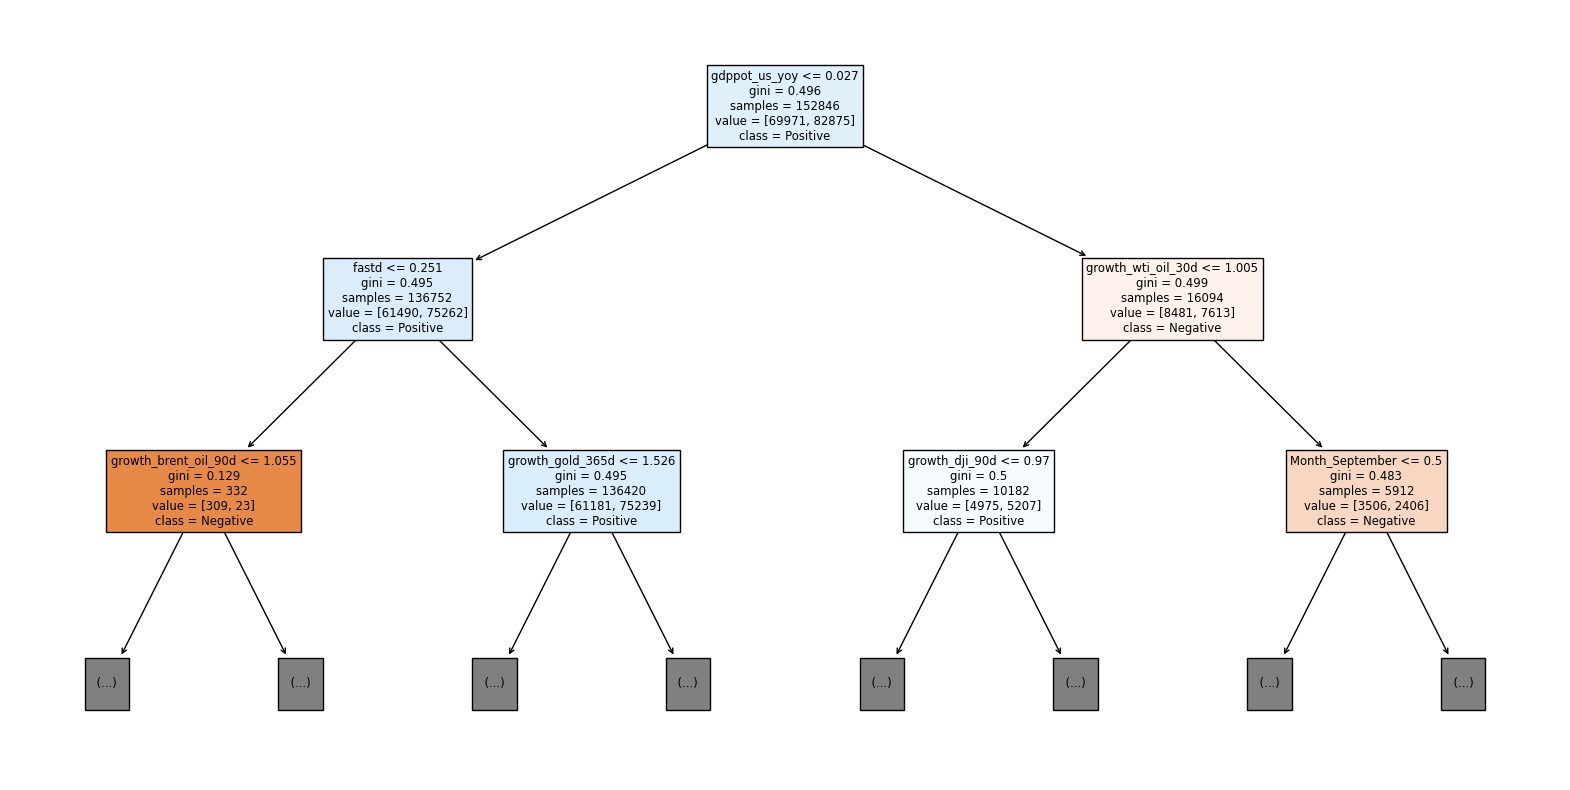

In [111]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is your trained DecisionTreeClassifier
plt.figure(figsize=(20,10))  # Set the size of the figure
plot_tree(clf_10,
          filled=True,
          feature_names=train_columns,
          class_names=['Negative', 'Positive'],
          max_depth=2)
plt.show()

In [112]:
# Feautures importance function to predict future returns (based on the classifier)
# get feature importance from 'clf' (classifier) and 'train_columns' (column names)

def get_importances(clf, train_columns):
  # Assuming clf is your trained DecisionTreeClassifier
  feature_importance = clf.feature_importances_

  # Assuming X_train is your training features
  feature_names = train_columns

  # Create a DataFrame to store feature importance
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

  # Sort the DataFrame by importance in descending order
  feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

  # Print or display the feature importance DataFrame
  # print(feature_importance_df)
  return feature_importance_df

In [113]:
get_importances(clf_10, train_columns).head(10)

,Feature,Importance
41,growth_wti_oil_365d,0.059830
35,growth_gold_365d,0.048691
183,DGS10,0.037753
22,growth_dji_90d,0.037333
178,cpi_core_yoy,0.036534
17,growth_snp500_365d,0.036081
39,growth_wti_oil_30d,0.026179
177,gdppot_us_qoq,0.025183
33,growth_gold_30d,0.025122
87,fastd,0.024045


### Question 4: (2 points) Hyperparameter tuning for a Decision Tree

What is the optimal tree depth (from 1 to 20) for a DecisionTreeClassifier?

NOTE: please include random_state=42 to Decision Tree Classifier init function (line clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)) to ensure consistency in results.

Follow these steps to find the optimal max_depth:

* Iterate through max_depth values from 1 to 20.
* Train the Decision Tree Classifier with the current max_depth parameter.
Optionally, visualize how the 'head' of each fitted tree changes with more advanced (=deep) trees.

You can use the sklearn.tree.plot_tree() function, or the compact way with the export_text() functionality (Stack Overflow example):

from sklearn.tree import export_text

tree_rules = export_text(model, feature_names=list(X_train), max_depth=3)

print(tree_rules)

* Calculate the precision score (you can use the function sklearn.metrics.precision_score()) on the TEST dataset for each of the fitted trees. You can also compare it with the precision score on a VALIDATION dataset, which is included to the training phase (to have more data to train on). You should see that the precision score on a VALIDATION set starts to grow with the complexity of a tree (overfit), which isn't seen on the precision score on TEST.
* Identify the optimal max_depth, where the precision score is the highest on the TEST dataset. Record this value as best_max_depth and submit as an answer.
* Make predictions on all records (TRAIN+VALIDATION+TEST) and add the new prediction pred6_clf_best to the dataframe new_df.

Additionally, compare the precision score of the tuned decision tree with previous predictions. You should observe an improvement (>0.58, or more than 58% precision), indicating that the tuned tree outperforms previous manual "hand" rules and Decision Tree predictions.

ADVANCED: Read more about different aspects of scikit-learn Decision Trees. Draw a line of precision/accuracy vs. max_depth and note whether there's a saturation point of precision/accuracy as max_depth increases. In theory, there should be a trade-off between better fitting (=more complex trees) and generalization.



In [114]:
# Define a function that fits the training data to decision tree of specified
# depth and computes the precision and accuracy of the prediction on test dataset

from sklearn.tree import export_text

def fit_predict_decision_tree(X_train:pd.DataFrame, y_train:pd.Series,
                              X_test:pd.DataFrame, y_test:pd.Series,
                              max_depth, random_state=42):

  # fit the classifier to the training data
  clf, _ = fit_decision_tree(X_train, y_train, max_depth, random_state)

  # predict the target variable on the test data
  y_pred = clf.predict(X_test)

  # Print the maximum depth
  print("Maximum depth of the decision tree:", max_depth)

  # Calculate the accuracy/precision of the model
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  print(f'Accuracy ={accuracy}, precision = {precision}')

  # Print tree heads for depths greater than or equal to 13
  if max_depth >= 13:
    tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
    print(tree_rules)

  return accuracy, precision

In [115]:
# iterate through depths of 1 to 20

random_state = 42
acc_list = []
prec_list = []

for depth in range(1, 21):
   accuracy, precision = fit_predict_decision_tree(X_train_imputed.drop(['Date','Ticker'],axis=1), y_train,
                                                   X_test_imputed.drop(['Date','Ticker'],axis=1), y_test,
                                                   depth, random_state)
   acc_list.append(accuracy)
   prec_list.append(precision)


Maximum depth of the decision tree: 1
Accuracy =0.5551979617151095, precision = 0.5551979617151095
Maximum depth of the decision tree: 2
Accuracy =0.5553655838278185, precision = 0.5552947488431359
Maximum depth of the decision tree: 3
Accuracy =0.5551979617151095, precision = 0.5551979617151095
Maximum depth of the decision tree: 4
Accuracy =0.5552650105601931, precision = 0.5552351895933215
Maximum depth of the decision tree: 5
Accuracy =0.5556002547856114, precision = 0.5554623258936063
Maximum depth of the decision tree: 6
Accuracy =0.5677696201682926, precision = 0.5711735485873952
Maximum depth of the decision tree: 7
Accuracy =0.5650206175198632, precision = 0.5683933475740006
Maximum depth of the decision tree: 8
Accuracy =0.5650206175198632, precision = 0.5683933475740006
Maximum depth of the decision tree: 9
Accuracy =0.5669985584498307, precision = 0.5699911670955106
Maximum depth of the decision tree: 10
Accuracy =0.5570418049549096, precision = 0.5652784277023866
Maximum d

In [116]:
# Find the maximum precision of the 20 trees
max(prec_list)

0.5864434133548517

In [117]:
# which tree has the max precision?
best_max_depth  = prec_list.index(max(prec_list)) + 1
best_max_depth

15

In [118]:
# fit the classifier to the training data for best tree
clf_best, _ = fit_decision_tree(X_train_imputed.drop(['Date','Ticker'],axis=1), y_train, best_max_depth, random_state)

# predict the target variable on the test data
y_pred = clf_best.predict(X_test_imputed.drop(['Date','Ticker'],axis=1))

In [119]:
y_all_pred = clf_best.predict(X_all_imputed.drop(['Date','Ticker'],axis=1))

In [120]:
y_pred.shape

(29829,)

In [121]:
y_all_pred.shape

(182675,)

In [122]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 331 entries, Open to is_correct_pred4
dtypes: datetime64[ns](2), float64(129), int32(178), int64(16), object(6)
memory usage: 338.7+ MB


In [123]:
new_df['pred6_clf_best'] = y_all_pred

In [124]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 332 entries, Open to pred6_clf_best
dtypes: datetime64[ns](2), float64(129), int32(178), int64(17), object(6)
memory usage: 340.1+ MB


In [125]:
new_df['pred6_clf_best'].value_counts()

pred6_clf_best
1    119076
0     63599
Name: count, dtype: int64

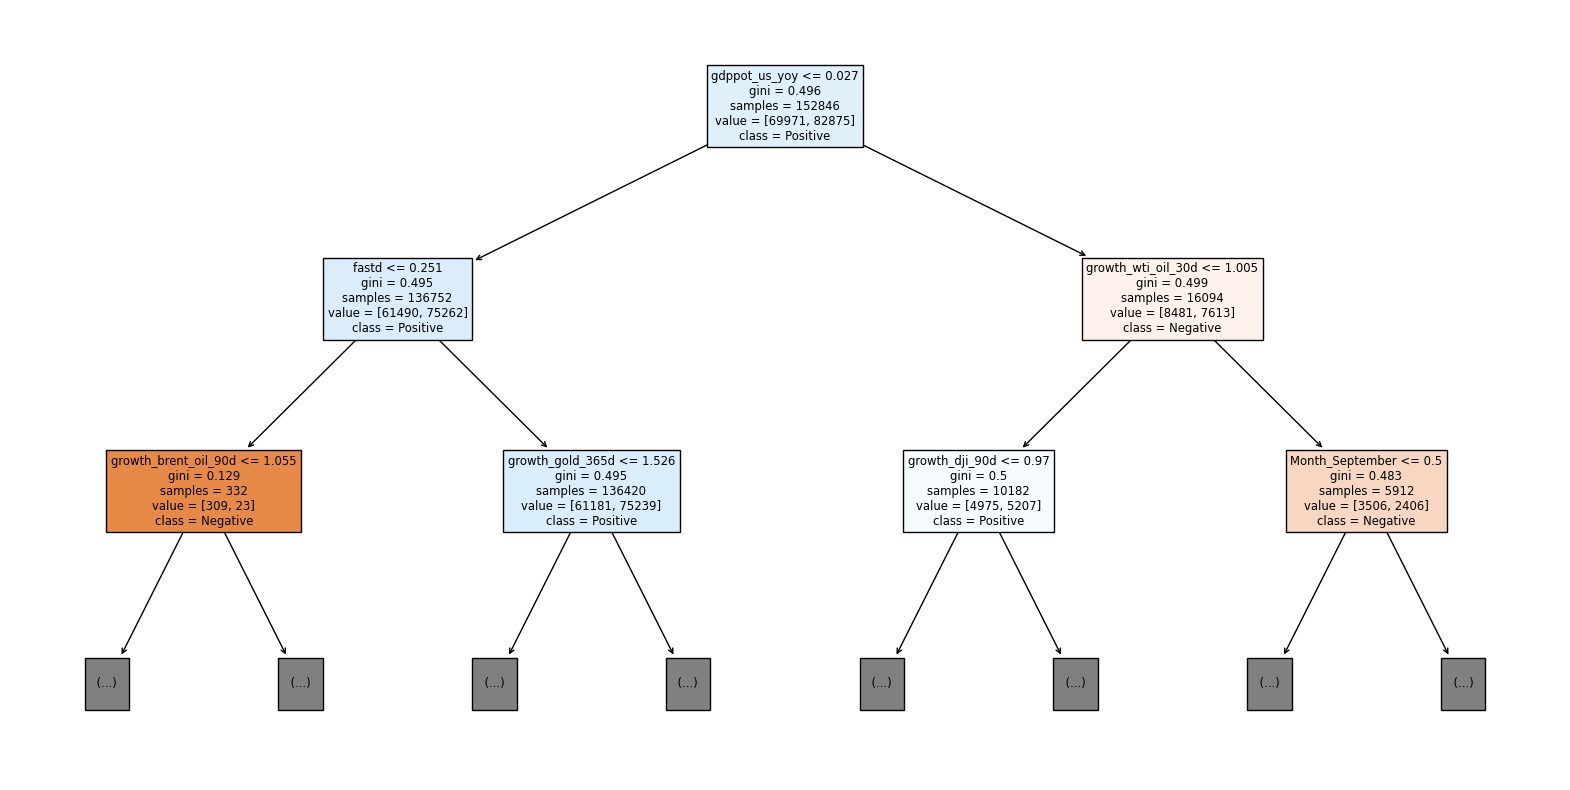

In [126]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is your trained DecisionTreeClassifier
plt.figure(figsize=(20,10))  # Set the size of the figure
plot_tree(clf_best,
          filled=True,
          feature_names=train_columns,
          class_names=['Negative', 'Positive'],
          max_depth=2)
plt.show()

In [127]:
get_importances(clf_best, train_columns).head(10)

,Feature,Importance
35,growth_gold_365d,0.028316
41,growth_wti_oil_365d,0.026872
39,growth_wti_oil_30d,0.026797
178,cpi_core_yoy,0.025237
183,DGS10,0.022334
5,growth_365d,0.019906
28,growth_epi_90d,0.019883
32,growth_gold_7d,0.019277
97,natr,0.018924
22,growth_dji_90d,0.018483
